In [1]:
!pip install lightly==1.4.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.6/647.6 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 9.5 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144575 sha256=798ef17b3af395d2117e04de52224dbb53e9102f5bad390269ce81c6ef3dd0d1
  Stored in directory: /root/.cache/pip/wheels/8b/8d/53/2af8772d9aec614e3fc65e53d4a993ad73c61daa8bbd85a873
Successfully built antlr4-python3-runtime


## Imports





In [2]:
# basic imports
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The dataset is a subset of [TAU Vehicle Type Recognition Competition data](https://www.kaggle.com/competitions/vehicle/data). It contains > 17000 RGB images of vehicles of following classes : `Ambulance, Bicycle, Bus, Car, Motorcycle, Taxi, Truck, Van`. We'll look at a few sample images from the dataset

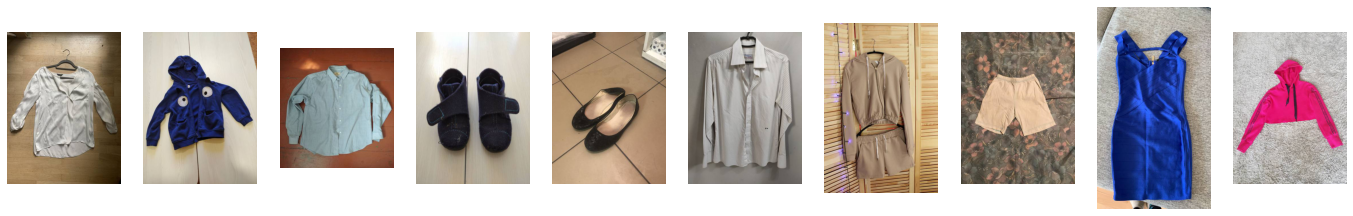

In [3]:
dataDir = '/kaggle/input/clothing-dataset/images'
filePaths = sorted([os.path.join(dataDir, x) for x in os.listdir(dataDir)])

from PIL import Image

fig, axes = plt.subplots(1,10, figsize= (24, 12))
for ax in axes.flatten():
    path = filePaths[np.random.randint(0, len(filePaths))]
    image = Image.open(path).convert('RGB')
    ax.imshow(image)
    ax.axis('off')

plt.show()

One thing to note is images are `object-centered`, of random sizes and from different viewpoints. Now that we've explored our data, we'll get more 'PyTorch friendly' and create a Dataset object, as well as a PyTorch Dataloader.

In [4]:
import cv2
import torch
from torch.utils.data import Dataset, DataLoader

class CLRDataset(Dataset):
    def __init__(self, rootDir, tf):
        self.rootDir = rootDir
        self.filePaths =  sorted([os.path.join(self.rootDir, x) for x in os.listdir(self.rootDir)])
        self.tf = tf
        
    def __len__(self):
        return len(self.filePaths)
    
    def __getitem__(self, index):
        # read source image and convert to RGB
        path = self.filePaths[index]        
        with open(path, "rb") as f:
            image = Image.open(f)
            image.convert("RGB")
    
        if self.tf is not None:
            image = self.tf(image)
        return image, path

- Now, we need to define the transformations for our images. In contrastive learning, we typically create multiple views of same scene and ask the model to differentiate b/w the same scene and different one as positive and negative samples. **Data augmentations play a key role**
- Specifically, we'll be using the transformations used in [SimCLR1](https://arxiv.org/abs/2002.05709) and [SimCLR2](https://arxiv.org/abs/2006.10029)
- Augmentaions used in SimCLR method are as follows:
    - Random resized crop
    - Random horizontal flip
    - Color jitter
    - Random gray scale
    - Gaussian blur
    - ImageNet normalization
    
**lightly** has already implemented a pytorch-friendly class of the above transformations. We can find similar implementaions for popular models in [lighlty transforms](https://github.com/lightly-ai/lightly/tree/master/lightly/transforms)

In [5]:
import torchvision
from lightly import transforms as lightly_transforms

input_size = 128
train_transform = lightly_transforms.SimCLRTransform(
                input_size=input_size, min_scale=0.25, rr_prob=0.5, rr_degrees=(-10,10))
train_dataset = CLRDataset(rootDir=dataDir, tf=train_transform)

We'll visualize augmentations applied on some of the samples

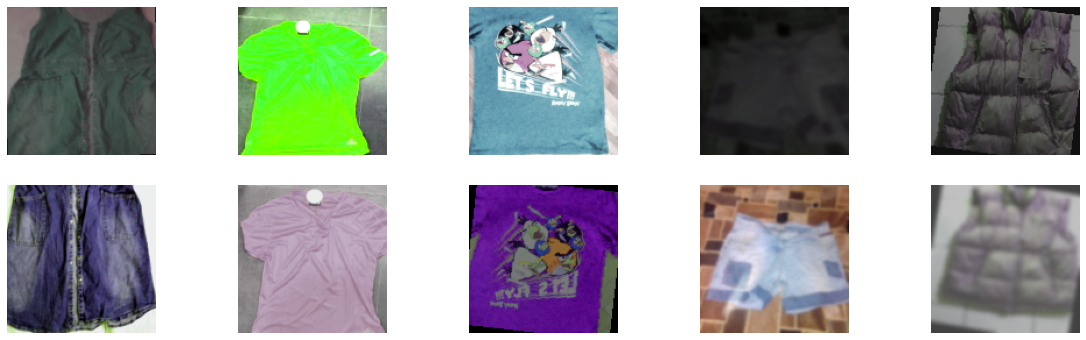

In [6]:
# when using torch datasets we defined earlier, the output image is normalized. 
# So we're defining an inverse transformation to transform to normal RGB format
inverse_transform = torchvision.transforms.Compose([
        torchvision.transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
    ])

def invert_normalize(inputImage):
    return inverse_transform(inputImage).permute(1, 2, 0).cpu().detach().numpy()

num_samples = 5
fig, axes = plt.subplots(2, num_samples, figsize= (20, 6))
for i in range(num_samples):
    (img_view1, img_view2), _ = train_dataset[np.random.randint(0, len(train_dataset))]
    
    # inverse normalization and plot view1
    img_view1 = invert_normalize(img_view1)
    axes[0, i].imshow(img_view1)
    axes[0, i].axis('off')
    
    # inverse normalization and plot view2
    img_view2 = invert_normalize(img_view2)
    axes[1, i].imshow(img_view2)
    axes[1, i].axis('off')


In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

## Model
Resnet50 backbone + SimCLR Projection head

In [8]:
import torch
import torch.nn as nn
from lightly.models.modules.heads import SimCLRProjectionHead

class SimCLRModel(nn.Module):
    def __init__(self):    
        super(SimCLRModel, self).__init__()
        # create a ResNet backbone and remove the classification head
        # The dilation parameters are given, as backbone will be reused with deeplabv3+ model
        backbone = torchvision.models.resnet50(pretrained=True, replace_stride_with_dilation =[False, True, True])
        self.initial = nn.Sequential(*list(backbone.children())[:4])
        self.layer1 = backbone.layer1
        self.layer2 = backbone.layer2
        self.layer3 = backbone.layer3
        self.layer4 = backbone.layer4
        self.avgpool = backbone.avgpool

        hidden_dim = backbone.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)
    
    def backbone_forward(self, x):
        # Pass input through Backbone layers
        x = self.initial(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x
        
    def forward(self, x):
        x = self.backbone_forward(x)
        x = self.avgpool(x).flatten(start_dim=1)
        return self.projection_head(x)         

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLRModel()
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [10]:
randomInput = torch.Tensor(32,3,128,128).to(device);
output = model(randomInput)
print(output.shape)  # each sample is compressed / projected to 128 dimensional feature vector

torch.Size([32, 128])


## Self-Supervised Contrastive Learning

In [11]:
from lightly.loss import NTXentLoss
# reference : https://docs.lightly.ai/self-supervised-learning/lightly.loss.html
# Contrastive Cross Entropy Loss as described in SimCLR paper
criterion = NTXentLoss()

# MODEL HYPERPARAMETERS
N_EPOCHS = 80
MAX_LR = 6e-2
MODEL_NAME = 'SimCLR_resnet50_clothing'


import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingWarmRestarts

# create model, optimizer, lr_scheduler
optimizer = optim.Adam(model.parameters(), lr=MAX_LR)
# scheduler = OneCycleLR(optimizer, max_lr= MAX_LR, epochs = N_EPOCHS,steps_per_epoch = len(train_dataloader), 
#                        pct_start=0.25, div_factor=10, anneal_strategy='cos')
# # scheduler = None
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0 = int(len(train_dataloader) * float(N_EPOCHS)/10), eta_min=3e-4)

In [12]:
# We monitor std.dev of the feature representations to see if model faces 
# feature-collapse, where model predicts same output for any input image
# If std.dev is 0, then outputs have collapsed to constant vector
# reference: https://arxiv.org/abs/2011.10566

from lightly.utils.debug import std_of_l2_normalized
from tqdm import tqdm

model.to(device); # move model to device

train_losses = []
std_devs = []
min_val_loss = np.Inf

for epoch in range(N_EPOCHS):    
    epoch_train_loss = 0.0
    epoch_std_devs = 0.0
    
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for (image_view1, image_view2), _ in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            # pass both views to model, calculate Contrastive loss
            image_view1, image_view2 = image_view1.to(device), image_view2.to(device)
            z0 = model(image_view1)
            z1 = model(image_view2)
            loss = criterion(z0, z1)
            
            # log values
            epoch_train_loss += loss.item()
            std_dev = std_of_l2_normalized(z1).item()
            epoch_std_devs += std_dev

            # Backward pass
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()
        
            tepoch.set_postfix(loss=loss.item(), std_dev=std_dev)
    
    last_epoch_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(last_epoch_loss)
    std_devs.append(epoch_std_devs / len(train_dataloader))
    
    # save model if loss has decreased
    if last_epoch_loss <= min_val_loss:
        min_val_loss = last_epoch_loss
        torch.save(model.state_dict(), f"{MODEL_NAME}.pt")

Epoch 79: 100%|██████████| 89/89 [01:20<00:00,  1.10batch/s, loss=3.37, std_dev=0.0736]


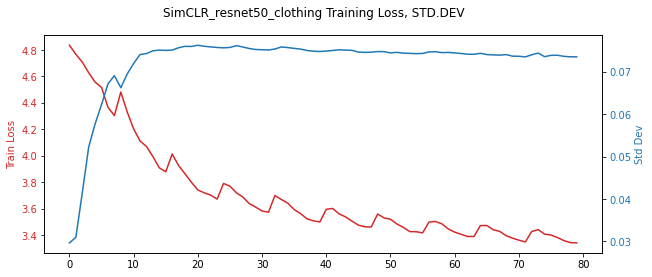

In [13]:
# visualize losses, std.devs
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.set_ylabel('Train Loss', color='tab:red')
ax1.plot(np.arange(N_EPOCHS), train_losses, color='tab:red')
ax1.tick_params(axis='y', labelcolor='tab:red')

ax2 = ax1.twinx()  
ax2.set_ylabel('Std Dev', color='tab:blue')
ax2.plot(np.arange(N_EPOCHS), std_devs, color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

plt.suptitle(f'{MODEL_NAME} Training Loss, STD.DEV')
plt.show()

## Evaluation using K-Nearest Neighbours
- As there are no labels, we'll evaluate the models using **k Nearest Neighbours**, one of the popular methods to evaluate Self-supervised models. We'll define a test dataset on same directory, but without any of the augmentations / transforms. 

In [14]:
# We'll define a test transform too, without any of the augmentations
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.Resize((input_size, input_size)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean= [0.485, 0.456, 0.406],  # imagenet mean
            std= [0.229, 0.224, 0.225],   # imagenet std.dev
        ),
    ]
)

test_dataset = CLRDataset(rootDir=dataDir, tf=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False, num_workers=2)

In [15]:
model.load_state_dict(torch.load(f'{MODEL_NAME}.pt', map_location=device))

<All keys matched successfully>

### Generate Embeddings for the entire dataset

In [16]:
from sklearn.preprocessing import normalize

def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """
    embeddings = []
    filenames = []
    with torch.no_grad():
        for img,fnames in tqdm(dataloader):
            img = img.to(device)
            emb = model.avgpool(model.backbone_forward(img)).flatten(start_dim=1)
            embeddings.append(emb.detach().cpu().numpy())
            filenames.extend(fnames)

    embeddings = np.concatenate(embeddings, axis=0)
    embeddings = normalize(embeddings)
    return embeddings, filenames


model.eval()
embeddings, filenames = generate_embeddings(model, test_dataloader)

100%|██████████| 90/90 [00:20<00:00,  4.36it/s]


In [17]:
print(embeddings.shape)

(5756, 2048)


## Visualize Nearest Neighbours

In [18]:
from sklearn.neighbors import NearestNeighbors

def get_image_as_np_array(filename: str):
    img = Image.open(filename)
    return np.asarray(img)

def plot_knn_examples(embeddings, filenames, n_neighbors=3, num_examples=6):
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)
    for idx in samples_idx:
        fig = plt.figure()
        
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            plt.imshow(get_image_as_np_array(filenames[neighbor_idx]))
            ax.set_title(f"d={distances[idx][plot_x_offset]:.3f}")
            plt.axis("off")

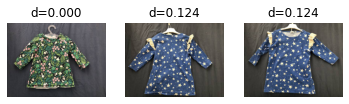

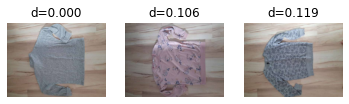

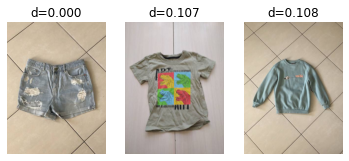

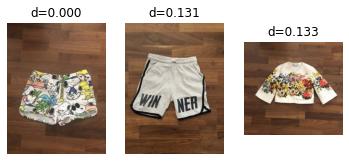

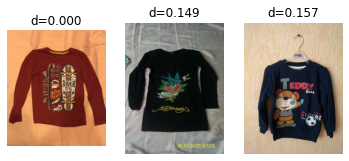

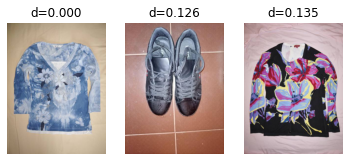

In [19]:
plot_knn_examples(embeddings, filenames)

## t-SNE plot
reference: https://builtin.com/data-science/tsne-python

In [20]:
# dataDistribution = {
#     'Ambulance' : 132,
#     'Bicycle' : 1618,
#     'Bus' : 2133,
#     'Car' : 6781,
#     'Motorcycle' : 2986,
#     'Taxi' : 748,
#     'Truck' : 2033,
#     'Van' : 1111,
# }